# Проект: классификация

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [19]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

### Задание 2

In [21]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [22]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].str.replace(',00', '')
df['balance']

0        2343
1          45
2        1270
3        2476
4         184
         ... 
11157       1
11158     733
11159      29
11160       0
11161       0
Name: balance, Length: 11162, dtype: object

### Задание 4

In [23]:
df['balance'] = df['balance'].astype (float)

In [24]:
df['balance'].mean()


1529.1290293615875

In [25]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df.fillna(df['balance'].median(), inplace = True)
df['balance'].mean()

1526.9360329690019

### Задание 5

In [26]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

m_job=df['job'].mode()[0]
m_edu=df['education'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)


In [27]:
df['education'].value_counts()

education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64

In [28]:
round(df[(df['education'] == 'secondary') & (df['job'] == 'management')] ['balance'].mean(),3)

1598.883

### Задание 6

In [34]:
def outliers_iqr(data, feature, left=1.5, right=1.5):
    """
    Функция для определения выбросов по методу Тьюки.

    :param data: Исходный датафрейм
    :param feature: Признак для которого определяют выбросы
    :param left: Множитель для определения левой границы выброса, по умолчанию 1.5
    :param right: Множитель для определения правой границы выброса, по умолчанию 1.5
    :return: Функция возвращает датафрейм с выбросами и отчищенный от выбросов датафрейм
    """  
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),  
    iqr = quartile_3 - quartile_1 
    lower_bound = quartile_1 - (iqr * left) 
    upper_bound = quartile_3 + (iqr * right)
     
    outliers = data[(x<lower_bound) | (x > upper_bound)]  
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    

In [35]:
outliers, cleaned = outliers_iqr(df, 'balance', left=1.5, right=1.5)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

TypeError: cannot unpack non-iterable NoneType object

In [32]:
df.drop(outliers.index, inplace=True)

NameError: name 'outliers' is not defined

In [29]:
df.balance.info()


<class 'pandas.core.series.Series'>
RangeIndex: 11162 entries, 0 to 11161
Series name: balance
Non-Null Count  Dtype  
--------------  -----  
11162 non-null  float64
dtypes: float64(1)
memory usage: 87.3 KB


In [ ]:
df.age.max()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
df.duration.min()

2

In [ ]:
df.deposit.value_counts()


no     5424
yes    4681
Name: deposit, dtype: int64

In [ ]:
df.balance.value_counts()

 0.0       774
 1.0        39
 2.0        34
 3.0        34
 550.0      31
          ... 
 650.0       1
-198.0       1
 1332.0      1
 1657.0      1
-134.0       1
Name: balance, Length: 2963, dtype: int64

## Часть 2:  Разведывательный анализ

### Задание 1

In [ ]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
import seaborn as sns
print(sns.__version__)
from seaborn import countplot
from matplotlib.pyplot import figure, show

0.12.2


### Задания 2 и 3

In [ ]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.job.describe(include = 'object')

count          10105
unique            11
top       management
freq            2315
Name: job, dtype: object

### Задания 4 и 5

In [ ]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

<AxesSubplot: xlabel='poutcome'>

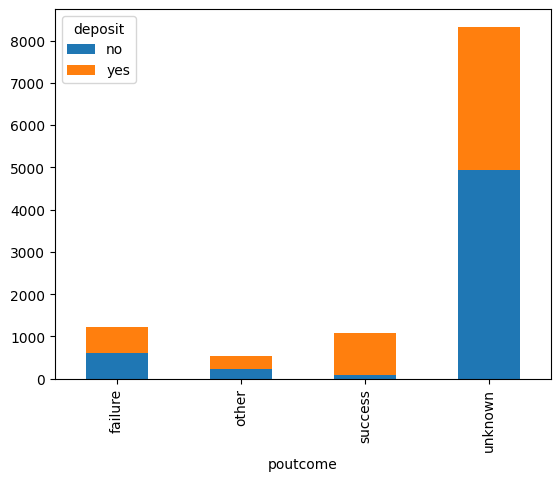

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
types=df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar',stacked='True')

### Задание 7

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код



### Задание 8

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

<AxesSubplot: xlabel='count', ylabel='marital'>

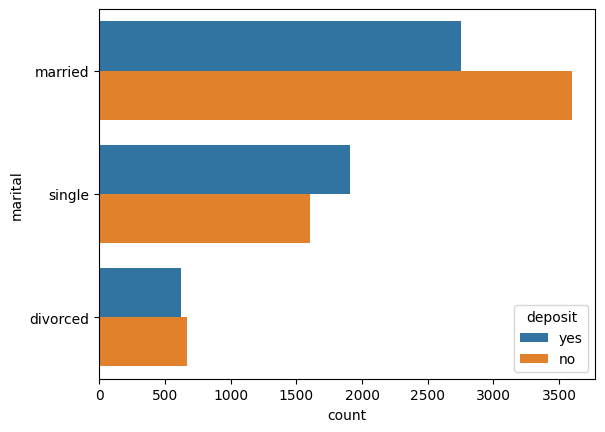

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=df)

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
rslt_df = df[(df['deposit'] == 'yes')] 
   
print('\nResult df :\n', rslt_df)


Result df :
       age           job   marital  education default  balance housing loan  \
0      59        admin.   married  secondary      no   2343.0     yes   no   
1      56        admin.   married  secondary      no     45.0      no   no   
2      41    technician   married  secondary      no   1270.0     yes   no   
3      55      services   married  secondary      no   2476.0     yes   no   
4      54        admin.   married   tertiary      no    184.0      no   no   
...   ...           ...       ...        ...     ...      ...     ...  ...   
5284   78       retired  divorced    primary      no   1389.0      no   no   
5285   30    management    single   tertiary      no    398.0      no   no   
5286   69       retired  divorced   tertiary      no    247.0      no   no   
5287   48  entrepreneur   married  secondary      no      0.0      no  yes   
5288   31        admin.    single  secondary      no    131.0     yes   no   

       contact  day month  duration  campaign  pd

In [ ]:
pd.crosstab(rslt_df.education, rslt_df.marital,values=de)

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


In [ ]:
heatmap = sns.heatmap(data=pd.crosstab, cmap='YlGnBu')
heatmap.set_title('Тепловая карта вакцинации')

ValueError: Must pass 2-d input. shape=()

In [ ]:
#(если рассматривать тех, кто открыл депозит)
rslt1_df = df[(df['deposit'] == 'no')] 
   
print('\nResult df :\n', rslt1_df)


Result df :
        age          job   marital  education default  balance housing loan  \
5289    57      retired    single          0      no    604.0      no   no   
5290    45       admin.  divorced          1      no      0.0     yes   no   
5291    48  blue-collar   married          1      no    238.0     yes  yes   
5292    34       admin.    single          1      no    673.0     yes   no   
5294    32   management   married          2      no   3696.0      no   no   
...    ...          ...       ...        ...     ...      ...     ...  ...   
11157   33  blue-collar    single          0      no      1.0     yes   no   
11158   39     services   married          1      no    733.0      no   no   
11159   32   technician    single          1      no     29.0      no   no   
11160   43   technician   married          1      no      0.0      no  yes   
11161   34   technician   married          1      no      0.0      no   no   

        contact  day month  duration  campaign  p

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования
lab_enc=LabelEncoder()
df['education']=lab_enc.fit_transform(df['education'])
df['education'].sum()

11995

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

NameError: name 'df' is not defined

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna